# PRT Defining Surface Types

_written by Jaren N. Ashcraft_

Polarization Ray Tracing (PRT) requires very explicit definition of light-matter interactions. In this tutorial, we will cover how to specify the different types of surfaces in Poke for accurate PRT.

## Reflective Systems
Poke was initially developed (in part) to be a tool for astronomical telescopes. Consequently, reflective systems were the first to be supported. Let us begin by setting up a `Rayfront` to model the Hubble Space Telescope. We begin as we do in the [Intro to Poke: Polarization Ray Tracing](introtopolarization.ipynb) demo.

In [1]:
from poke.poke_core import Rayfront
from poke.poke_math import np

pth_to_lens = 'C:/Users/Work/Desktop/poke/test_files/Hubble_Test.zmx'

# rayfront parameters
number_of_rays = 20 # across the entrance pupil
wavelength = 0.6e-6
pupil_radius = 1.2 # semi-aperture of Hubble
max_field_of_view = 0.08 # degrees

rf = Rayfront(number_of_rays, wavelength, pupil_radius, max_field_of_view, circle=False)

norm fov =  [0. 0.]
base ray shape  (4, 400)


### Single-Layer Coatings

The single-layer coatings are handled using [Fresnel's equations](https://en.wikipedia.org/wiki/Fresnel_equations). To specify them in Poke, simply supply the `coating` key of the surface dictionary with a float `n_film`. 

In [2]:
n_film = 1.200 + 1j*7.260

m1 = {"surf": 2, "coating": n_film, "mode": "reflect"}
m2 = {"surf": 4, "coating": n_film, "mode": "reflect"}
m3 = {"surf": 8, "coating": n_film, "mode": "reflect"}

surflist = [m1, m2, m3]

We can then proceed with running the raytrace and computing the Jones pupil.

In [3]:
import zosapi
zosapi.App()

rf.as_polarized(surflist)
rf.trace_rayset(pth_to_lens)
rf.compute_jones_pupil(aloc=np.array([0., 1., 0.]))

tracing with global coordinates
tracing with global coordinates
tracing with global coordinates
1 Raysets traced through 3 surfaces


Plotting the Jones pupil reveals that everything looks about right for a Cassegrain telescope with a fold mirror! 

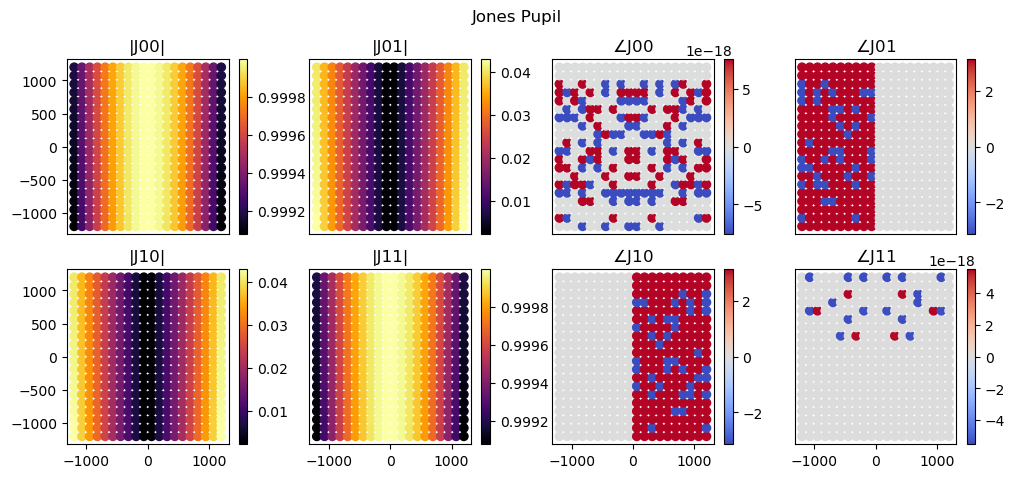

In [4]:
import poke.plotting as plot
plot.jones_pupil(rf)

### Multilayer coating
Frequently telescope mirrors will be coated with some dielectric material to protect or enhance the coating. Here we invoke the multilayer thin-film algorithm from [Peatross and Ware Chapter 4.7](https://optics.byu.edu/docs/opticsbook.pdf) to compute the effective reflection coefficients for PRT. For this coating, we will also define a dielectric substrate to deposit the metal on, since telescope mirrors are frequently metal films deposited on lightweighted glass.

The multilayer coating specification must be a **_list_** for Poke to recognize it as a multilayer stack. Here we define the coating as a list of tuples containing index in the first position and thickness in the second. The order that the surface appears in the list is the order that light hits the film. The final element of the list is a substrate, which is assumed to be semi-infinite and does not require a thickness.

In [5]:
n_substrate = 1.5

n_Al = 1.200 + 1j*7.260
d_Al = 1000e-9

n_SiO2 = 1.4580
d_SiO2 = 50e-9

coating = [
    (n_SiO2, d_SiO2),
    (n_Al, d_Al),
    (n_substrate)
]

Lets update our `Rayfront` with these data and compute the Jones pupil

In [6]:
m1 = {"surf": 2, "coating": coating, "mode": "reflect"}
m2 = {"surf": 4, "coating": coating, "mode": "reflect"}
m3 = {"surf": 8, "coating": coating, "mode": "reflect"}

surflist = [m1, m2, m3]
rf.surfaces = surflist
rf.compute_jones_pupil(aloc=np.array([0., 1., 0.]))

We can see that the addition of a dielectric layer, even a thin one, changes the phase pretty dramatically!

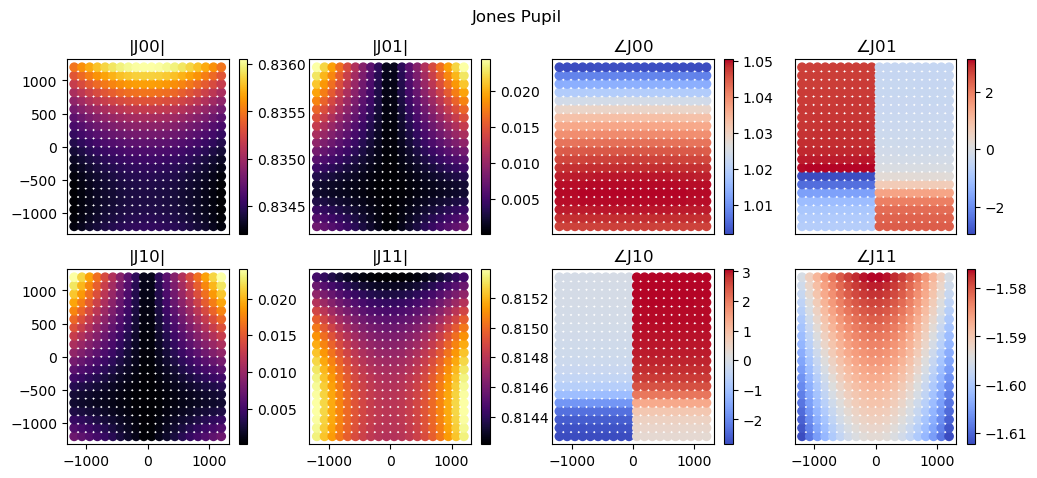

In [7]:
plot.jones_pupil(rf)

Poke also happens to support another thin film algorithm for comparison. Macleod employs a similar thin film algorithm where the refractive index sign convention is assumed to be negative, which we've included in Poke. 

This is not Poke's default, so if you wish to change it, you can do so by updating Poke's configuration.

In [8]:
from poke.conf import Config

Config.refractive_index_sign = "negative"

Now we update the sign of the imaginary component is flipped and re-compute the Jones pupil

In [9]:
n_Al = 1.200 - 1j*7.260

coating = [
    (n_SiO2, d_SiO2),
    (n_Al, d_Al),
    (n_substrate)
]

m1 = {"surf": 2, "coating": coating, "mode": "reflect"}
m2 = {"surf": 4, "coating": coating, "mode": "reflect"}
m3 = {"surf": 8, "coating": coating, "mode": "reflect"}

surflist = [m1, m2, m3]
rf.surfaces = surflist
rf.compute_jones_pupil(aloc=np.array([0., 1., 0.]))

This happens to flip the sign of the Jones pupil's phase, but otherwise the amplitudes and phases look identical. 

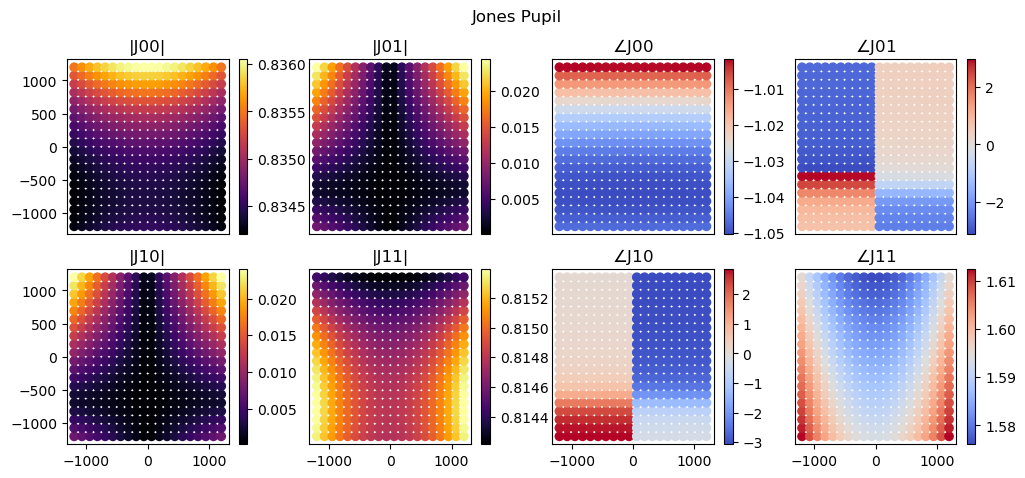

In [10]:
plot.jones_pupil(rf)

## Refractive Systems

Refractive surfaces use a very similar interface to the one above, but require that we keep track of the index in the incident and exiting medium. For this section we will use a fast (F/1) singlet composed of a high refractive index material `n = 2`.

### Single-Layer Coatings
Single-layer coatings for refractive material follow pretty directly from the reflective example, we just need to be sure to supply another index. First, we set up a new `Rayfront`.

In [11]:
pth_to_lens = 'C:/Users/Work/Desktop/poke/experiments/physics_validation/singlet.zmx'

# rayfront parameters
number_of_rays = 20 # across the entrance pupil
wavelength = 0.6e-6
pupil_radius = 50e-3 # semi-aperture of Hubble
max_field_of_view = 1 # degrees

rf = Rayfront(number_of_rays, wavelength, pupil_radius, max_field_of_view, circle=True)

norm fov =  [0. 0.]
base ray shape  (4, 276)


To specify a single-layer refractive interation, Poke uses tuples as shown below to describe entering or exiting a dielectric material. Here we specify the first surface of the lens as the `front` and second surface of the lens as the `rear`.

In [12]:
n_air = 1.
n_glass = 2.

n_front = (n_air, n_glass)
n_rear = (n_glass, n_air)


front = {"surf": 1, "coating": n_front, "mode": "transmit"}
rear = {"surf": 2, "coating": n_rear, "mode": "transmit"}

In [13]:
rf.as_polarized([front, rear])
rf.trace_rayset(pth_to_lens)
rf.compute_jones_pupil(aloc=np.array([0., 0., 1.]))

tracing with global coordinates
tracing with global coordinates
1 Raysets traced through 2 surfaces


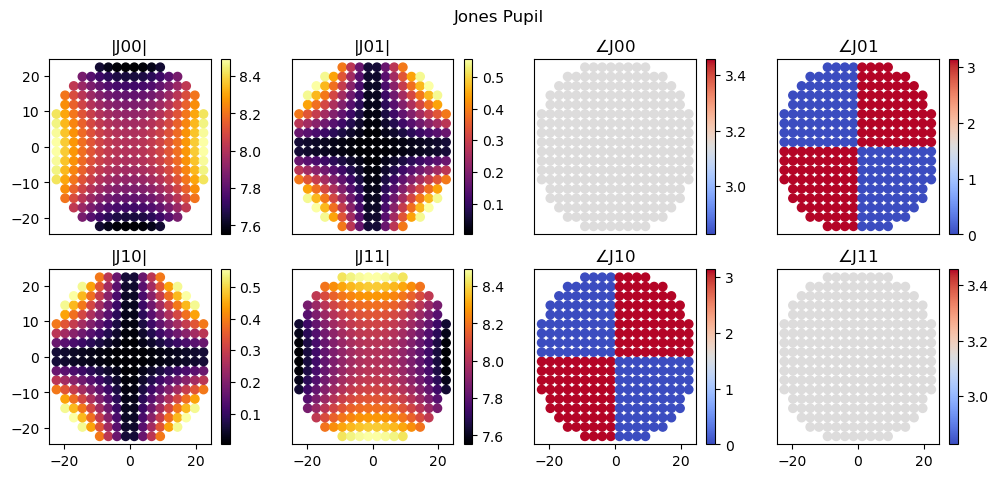

In [14]:
plot.jones_pupil(rf, coordinates='polar')

C:\Users\Work\Desktop\poke\poke\polarization.py:92: RuntimeWarning: invalid value encountered in arcsin
  aor = np.arcsin(n1 * np.sin(aoi) / n2)


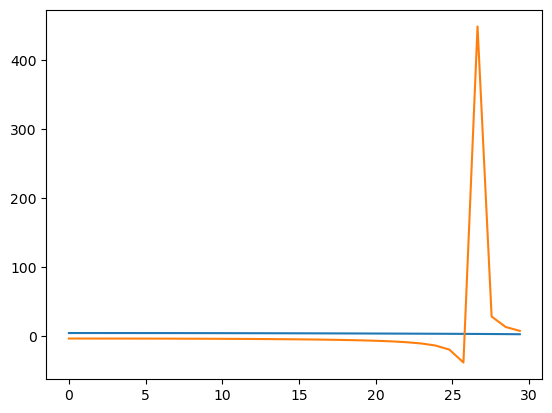

In [26]:
from poke.polarization import fresnel_coefficients
angles = np.linspace(0,np.pi/4)
ts, tp = fresnel_coefficients(angles, n_glass, n_air, mode='transmit')
ts, tp = fresnel_coefficients(angles, n_glass, n_air, mode='transmit')
plt.plot(np.degrees(angles), ts)
plt.plot(np.degrees(angles), tp)

In [15]:
parent_pth = 'C:/Users/Work/Desktop/poke/experiments/physics_validation/'

xpol = np.genfromtxt(parent_pth+'singlet__xin_600nm.txt', skip_header=1).T
ypol = np.genfromtxt(parent_pth+'singlet__yin_600nm.txt', skip_header=1).T
x, y = xpol[0], xpol[1]

Exx = xpol[3] + 1j*xpol[4]
Exy = xpol[5] + 1j*xpol[6]
Eyx = ypol[3] + 1j*ypol[4]
Eyy = ypol[5] + 1j*ypol[6]

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=[3,3])
plt.scatter(x, y, c=np.abs(Eyy), cmap='inferno')
plt.colorbar()
plt.show()

NameError: name 'x' is not defined

<Figure size 300x300 with 0 Axes>

In [17]:
Exx.shape

(385,)

In [18]:
rf.xData[0,0,0]-rf.xData[0,0,1]

-2.6315789473684195

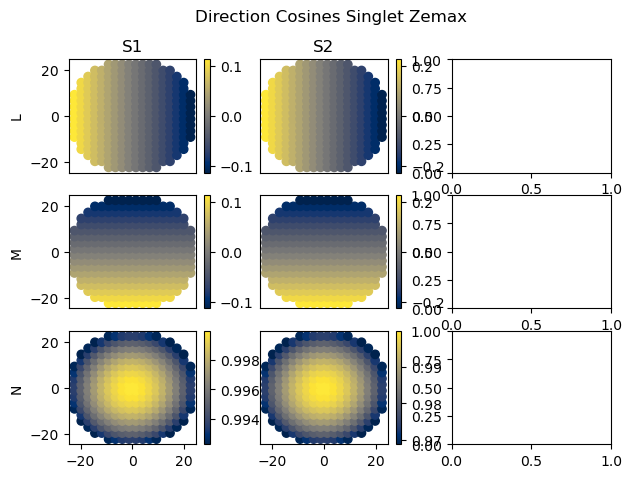

In [19]:
import matplotlib.pyplot as plt

def plot_raydir(rf, rf2=None, code='Zemax', cmap='cividis'):
    fig, axs = plt.subplots(figsize=[7, 5], nrows=3, ncols=3)
    plt.suptitle(f"Direction Cosines Singlet {code}")
    for j in range(3):
        for k in range(2):
            
            ax = axs[j, k]

            if j == 0:
                if rf2 is None:
                    data = rf.lData[0, k]
                else:
                    data = rf.lData[0, k] - rf2.lData[0, k]
                ax.set_ylabel('L')
                ax.set_title(f'S{k+1}')

            elif j == 1:
                if rf2 is None:
                    data = rf.mData[0, k]
                else:
                    data = rf.mData[0, k] - rf2.mData[0, k]
                ax.set_ylabel('M')

            elif j == 2:
                if rf2 is None:
                    data = rf.nData[0, k]
                else:
                    data = rf.nData[0, k] - rf2.nData[0, k]
                ax.set_ylabel('N')

            sca = ax.scatter(rf.xData[0,0], rf.yData[0,0], c=data, cmap=cmap)
            fig.colorbar(sca, ax=ax)

            # clear interior axes
            if j < 2:
                ax.xaxis.set_visible(False)

            if k > 0:
                ax.yaxis.set_visible(False)

plot_raydir(rf)
from poke.raytrace import convert_ray_data_to_prt_data
aoi, kin, kout, norm = convert_ray_data_to_prt_data(rf.lData[0], rf.mData[0], rf.nData[0],
                                    rf.l2Data[0], rf.m2Data[0], rf.n2Data[0],
                                    rf.surfaces, ambient_index=1)

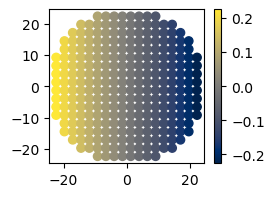

In [20]:
plt.figure(figsize=[2.5,2])
plt.scatter(rf.xData[0,0], rf.yData[0,0], c=kout[1][0], cmap='cividis')
plt.colorbar()
plt.show()

In [21]:
kout[0].shape

(3, 276)

## Custom Surfaces
numpy arrays, callables

(1, 2)